In [1]:
cd dataset

C:\Users\Miya\Desktop\cna\dataset


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('repositories_refined.csv',parse_dates=['Month, Day, Year of Date'])
#data = data[data['Coding Effort']!=0]
data.columns= ['Worker ID','Repository ID','Coding Effort','Month, Day, Year of Date']

In [4]:
data.head()

,Worker ID,Repository ID,Coding Effort,"Month, Day, Year of Date"
0,aaa,AAA,0.00,2015-07-01
1,dxw,HEL,5.00,2015-07-01
2,woe,WHS,4.73,2015-07-01
3,woe,EZR,0.26,2015-07-01
4,wlk,RJA,5.00,2015-07-01


In [3]:
X_test = data[data['Month, Day, Year of Date']>='2015-07-08']
X_train = data[data['Month, Day, Year of Date']<'2015-07-08']

In [4]:
data[data['Month, Day, Year of Date']<'2015-07-08'].head()

,Worker ID,Repository ID,Coding Effort,"Month, Day, Year of Date"
0,aaa,AAA,0.00,2015-07-01
1,dxw,HEL,5.00,2015-07-01
2,woe,WHS,4.73,2015-07-01
3,woe,EZR,0.26,2015-07-01
4,wlk,RJA,5.00,2015-07-01


In [5]:
def dirty_model():
    pred_base = []
    tp = data[data['Month, Day, Year of Date']<'2015-07-08'].groupby(['Worker ID','Repository ID']).sum().reset_index()
    for deve in to_predict_deve:
        old = tp[tp['Worker ID']==deve]['Repository ID']
        new = [i for i in Most_popu_repo if i not in old]
    pred_base.append(new)
    
    return pred_base

In [6]:
Most_popu_repo = data[data['Month, Day, Year of Date']<'2015-07-08'].groupby('Repository ID').count().sort_values('Worker ID',ascending = False).index

In [7]:
print(X_train.shape)
print(X_test.shape)

(13155, 4)
(159199, 4)


In [8]:
deve_nodes_train = list(set(X_train.values[:,0]))
deve_nodes_test = list(set(X_test.values[:,0]))

In [9]:
X_test = X_test[X_test['Worker ID'].isin([test for test in deve_nodes_test if test in deve_nodes_train])]

In [10]:
X_test = X_test.groupby(['Worker ID','Repository ID']).sum().reset_index()

In [11]:
t1 = pd.DataFrame(X_train['Worker ID']+X_train['Repository ID'],columns = ['temp'])
t2 = pd.DataFrame(X_test['Worker ID']+X_test['Repository ID'],columns = ['temp'])

In [12]:
X_test = X_test[~t2['temp'].isin(t1['temp'])]

In [13]:
sum(pd.DataFrame(X_test["Worker ID"]+X_test["Repository ID"])[0].isin(t1['temp']))

0

In [14]:
X_test.shape

(2775, 3)

In [15]:
len(list(set(X_test.values[:,0])))

945

In [16]:
len(list(set(X_train.values[:,0])))

2321

In [17]:
X_train = X_train.groupby(['Worker ID','Repository ID']).sum().reset_index().values

In [18]:
X_test.shape[0]/X_train.shape[0]

0.8748423707440101

In [19]:
actual_list = []
to_predict_deve = set(X_test['Worker ID'])
print(len(to_predict_deve))
for dev in to_predict_deve:
    repo = X_test[X_test['Worker ID']==dev]['Repository ID'].values
    actual_list.append(list(repo))

945


In [20]:
import networkx as nx
%matplotlib inline
from networkx.algorithms import bipartite
G_train = nx.Graph()
for i,v,j in zip(X_train[:,0],X_train[:,1],X_train[:,2]):
    G_train.add_edge(i,v,weight = j)

In [21]:
nx.write_gml(G_train,'g_2.gml')

In [22]:
deve_nodes = list(set(X_train[:,0]))

In [23]:
def normalize(x):
    if x==0:
        x = 1
    else:
        x
    return x

def my_weight(G_train, u, v, weight='weight'):
    w = 0
    for nbr in set(G_train[u]) & set(G_train[v]):
        u_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[u].values()))))
        v_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[v].values()))))
        nbr_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[nbr].values()))))
        
        w += (G_train.edge[u][nbr].get(weight,1)/u_sum) * (G_train.edge[v][nbr].get(weight,1)/nbr_sum)
        return w 
    
    
def jaccard(G, u, v):
    unbrs = set(G[u])
    vnbrs = set(G[v])
    return float(len(unbrs & vnbrs)) / len(unbrs)

In [24]:
def project_graph(G_train,method = 'binary'):
    
    if method =='binary':
        graph = nx.projected_graph(G_train,deve_nodes)
    if method == 'my_weight':
        graph = bipartite.generic_weighted_projected_graph(G_train, deve_nodes, weight_function= my_weight)
        graph = nx.Graph(graph) 
    if method == 'jaccard':
        graph = bipartite.generic_weighted_projected_graph(G_train, deve_nodes, weight_function= jaccard)
        graph = nx.Graph(graph) 

    return graph

for m in ['binary','my_weight','jaccard']:
    graph = project_graph(G_train,method = m)
    nx.write_gml(graph,m+'.gml')

In [28]:
import itertools
def neighbors_cluster(node, method = 'binary' ):
    
    refer = pd.read_csv(method+'.csv').set_index('nodes')    
    ml = refer.ix[node,0]
    info = refer.ix[node,1]
    wt = refer.ix[node,2]
    fg = refer.ix[node,3]
    lp = refer.ix[node,4]
    kmeans = refer.ix[node,5]
    gmm = refer.ix[node,6]
    
    ml_nn = refer[refer['ml_member']==ml].index
    wt_nn = refer[refer['wt_member']==wt].index
    info_nn = refer[refer['info_member']==info].index
    fg_nn = refer[refer['fg_member']==fg].index
    lp_nn = refer[refer['lp_member']==lp].index
    kmeans_nn = refer[refer['kmeans']==kmeans].index
    gmm_nn = refer[refer['gmm']==kmeans].index
    
    cluster_nn = list(itertools.chain(wt_nn,kmeans_nn,lp_nn,fg_nn,gmm_nn)) #ml_nn,info_nn
    
    return cluster_nn

In [30]:
def neighbors_cluster_weighted(node, method = 'binary'):
    
    refer = pd.read_csv(method+'.csv').set_index('nodes') 
    
    ml = refer.ix[node,0]
    info = refer.ix[node,1]
    wt = refer.ix[node,2]
    fg = refer.ix[node,3]
    lp = refer.ix[node,4]
    kmeans = refer.ix[node,5]
    gmm = refer.ix[node,6]
    
    ml_nn = refer[refer['ml_member']==ml].index
    wt_nn = refer[refer['wt_member']==wt].index
    info_nn = refer[refer['info_member']==info].index
    fg_nn = refer[refer['fg_member']==fg].index
    lp_nn = refer[refer['lp_member']==lp].index
    kmeans_nn = refer[refer['kmeans']==kmeans].index
    gmm_nn = refer[refer['gmm']==kmeans].index
    

    
    return wt_nn,kmeans_nn,ml_nn,info_nn,fg_nn,lp_nn,gmm_nn

In [31]:
K = 100
def limit_k(rs_list, k = K):
    if len(rs_list)<k:
        return rs_list
    else:
        return rs_list[:k]  

In [34]:
def ensemble_similarity(node,wf):
    
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    cluster_nn = neighbors_cluster(node,method = 'binary')
    
    dict_rs = dict()
    
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*np.exp(we)

        
    for nn in cluster_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*1
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [50]:
def community_weight(method = 'binary'):
    
    df = pd.read_csv(method +'.csv').set_index('nodes')
    wt_w = len(df['wt_member'].unique())/100
    ml_w = len(df['ml_member'].unique())/100
    info_w = len(df['info_member'].unique())/100
    fg_w = len(df['fg_member'].unique())/100
    lp_w = len(df['lp_member'].unique())/100
    
    return wt_w,ml_w,info_w,fg_w,lp_w

In [36]:
def ensemble_similarity_weighted(node,wf,method = 'binary'):
    
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    
    wt_nn,kmeans_nn,ml_nn,info_nn,fg_nn,lp_nn,gmm_nn = neighbors_cluster_weighted(node, method = 'binary')
    
    wt_w,ml_w,info_w,fg_w,lp_w = community_weight()
     
    dict_rs = dict()
    
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*np.exp(we)

        
    for nn in wt_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*wt_w

    for nn in ml_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*ml_w

    for nn in info_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*info_w
            
    for nn in kmeans_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*n_clusters/100
            
    for nn in fg_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*fg_w
            
    for nn in lp_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*lp_w
            
    for nn in gmm_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*cluster_gmm/100
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [37]:
def projection_similarity(node,wf):
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    
    dict_rs = dict()
    
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*np.exp(we)
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [38]:
def cluster_similarity(node):
    
    dict_rs = dict()
    cluster_nn = neighbors_cluster(node, method = 'binary')

    for nn in cluster_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [39]:
def cluster_similarity_weighted(node):
    
    dict_rs = dict()
    
    wt_nn,kmeans_nn,ml_nn,info_nn,fg_nn,lp_nn,gmm_nn = neighbors_cluster_weighted(node, method = 'binary')
    
    wt_w,ml_w,info_w,fg_w,lp_w = community_weight()

    for nn in wt_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*wt_w

    for nn in ml_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*ml_w

    for nn in info_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*info_w
            
    for nn in kmeans_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*n_clusters/100
            
    for nn in fg_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*fg_w
            
    for nn in lp_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*lp_w

    for nn in gmm_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*cluster_gmm/100
        
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [40]:
def accuracy(actual, predicted, k= K):
    if len(predicted)>k:
        predicted = predicted[:k]
    
    eva = [p for p in predicted if p in actual]
    
    if len(eva)!=0:
        score  = 1
    else:
        score = 0 

    return score 

def accuracy_mean(actual_list, predicted_list, k= 20):

    return np.mean([accuracy(a,p,k) for a,p in zip(actual_list, predicted_list)])
    

In [41]:
def apk(actual, predicted, k= K):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual_list, predicted_list, k= 20):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
            
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual_list, predicted_list)])

In [42]:
def similarity_rs(node_list, choice = "projection_similarity",wf = my_weight):
    
    tp = data[data['Month, Day, Year of Date']<'2015-07-08'].groupby(['Worker ID','Repository ID']).sum().reset_index()
    
    dict_rs = dict()
    
    for node in node_list:
        if choice == 'projection_similarity':
             rs_list = projection_similarity(node,wf)
        if choice == 'cluster_similarity':
             rs_list = cluster_similarity(node)
        if choice == 'cluster_similarity_weighted':
             rs_list = cluster_similarity_weighted(node)
        if choice == 'ensemble_similarity_weighted':
             rs_list = ensemble_similarity_weighted(node,wf)
        if choice == 'ensemble_similarity':
             rs_list = ensemble_similarity(node,wf)
        if choice == 'ensemble_similarity_weighted_half':
            rs_list=[]
            rs_list1 = cluster_similarity_weighted(node)
            rs_list2 = projection_similarity(node,wf)
            for p, sw in zip(rs_list2, rs_list1):
                rs_list.append(p)
                rs_list.append(sw)
            rs_list = limit_k(list(set(rs_list)),k=100)
            
            
        old = tp[tp['Worker ID']==node]['Repository ID']
        rs_list = [i for i in rs_list if i not in old]
            
    
        dict_rs[node] = rs_list
    
    return dict_rs

**Base Model:** binary projection + cluster + community detection

** Models:** 
* my_weight projection 
* jaccard projection
* my_weight projection + cluster 
* jaccard projection + cluster 
* my_weight projection + cluster weighted 
* jaccard projection + cluster weighted


In [43]:
cluster_gmm = 75
n_clusters= 20
top_K = 10

# baseline model

In [44]:
method = 'binary'

y_predict_dict_c = similarity_rs(to_predict_deve, choice = "cluster_similarity",wf = my_weight)

In [45]:
print(accuracy_mean(actual_list, y_predict_dict_c.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_c.values(), k= top_K))

0.293121693122
0.0798091948714


# Weighted Projection

In [46]:
y_predict_dict_p = similarity_rs(to_predict_deve, choice = "projection_similarity",wf = my_weight)
y_predict_dict_p_j = similarity_rs(to_predict_deve, choice = "projection_similarity",wf = jaccard)

In [47]:
print(accuracy_mean(actual_list, y_predict_dict_p.values(), k=  top_K))
print(accuracy_mean(actual_list, y_predict_dict_p_j.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_p.values(), k= top_K))
print(mapk(actual_list, y_predict_dict_p_j.values(), k= top_K))

0.500529100529
0.500529100529
0.146479660824
0.146488262207


# Cluster on Binary Ensemble

In [51]:
method = 'binary'

y_predict_dict_c_w = similarity_rs(to_predict_deve, choice = "cluster_similarity_weighted",wf = my_weight)
y_predict_dict_e = similarity_rs(to_predict_deve, choice = "ensemble_similarity",wf = my_weight)
y_predict_dict_e_w = similarity_rs(to_predict_deve, choice = "ensemble_similarity_weighted",wf = my_weight)
y_predict_dict_e_w_h = similarity_rs(to_predict_deve, choice = "ensemble_similarity_weighted_half",wf = my_weight)

In [52]:
print(accuracy_mean(actual_list, y_predict_dict_c_w.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_c_w.values(), k= top_K))
print('---')
print(accuracy_mean(actual_list, y_predict_dict_e.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_e.values(), k= top_K))
print('---')
print(accuracy_mean(actual_list, y_predict_dict_e_w.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_e_w.values(), k= top_K))
print('---')
print(accuracy_mean(actual_list, y_predict_dict_e_w_h.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_e_w_h.values(), k= top_K))

0.447619047619
0.146583506301
---
0.301587301587
0.0824225263984
---
0.448677248677
0.146797750023
---
0.47619047619
0.177189410058


In [53]:
y_predict_dict_c_w = similarity_rs(to_predict_deve, choice = "cluster_similarity_weighted",wf = jaccard)
y_predict_dict_e = similarity_rs(to_predict_deve, choice = "ensemble_similarity",wf = jaccard)
y_predict_dict_e_w = similarity_rs(to_predict_deve, choice = "ensemble_similarity_weighted",wf = jaccard)
y_predict_dict_e_w_h = similarity_rs(to_predict_deve, choice = "ensemble_similarity_weighted_half",wf = jaccard)

In [54]:
print(accuracy_mean(actual_list, y_predict_dict_c_w.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_c_w.values(), k= top_K))
print('---')
print(accuracy_mean(actual_list, y_predict_dict_e.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_e.values(), k= top_K))
print('---')
print(accuracy_mean(actual_list, y_predict_dict_e_w.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_e_w.values(), k= top_K))
print('---')
print(accuracy_mean(actual_list, y_predict_dict_e_w_h.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_e_w_h.values(), k= top_K))

0.447619047619
0.146583506301
---
0.316402116402
0.0874192861742
---
0.448677248677
0.147629809596
---
0.47619047619
0.17711854838


In [268]:
## R run associated graph
    
def generate_communities(method = method):
    
    print(method)
    
    wt = pd.read_csv('wt_df.csv')
    wt.columns = ['wt_member','nodes']
    ml = pd.read_csv('ml_df.csv')
    ml.columns = ['ml_member','nodes']

    info = pd.read_csv('info_df.csv')
    info.columns = ['info_member','nodes']

    fg = pd.read_csv('fg_df.csv')
    fg.columns = ['fg_member','nodes']

    lp = pd.read_csv('lp_df.csv')
    lp.columns = ['lp_member','nodes']
    
    temp = pd.merge(ml,info, how='inner', on='nodes')
    temp = pd.merge(temp,wt, how='inner', on='nodes')
    temp = pd.merge(temp,fg, how='inner', on='nodes')
    temp = pd.merge(temp,lp, how='inner', on='nodes')
    
    graph = project_graph(G_train,method = method)
    
    
    degree_df = pd.DataFrame.from_dict({'nodes':list(nx.degree(graph).keys()),'Degree':list(nx.degree(graph).values())})
    betweenness_df = pd.DataFrame({'between':list(nx.betweenness_centrality(graph).values())})
    close_df = pd.DataFrame({'close':list(nx.closeness_centrality(graph).values())})
    eigen_df = pd.DataFrame({'eigen':list(nx.eigenvector_centrality_numpy(graph).values())})
    pager_df = pd.DataFrame({'pagerank':list(nx.pagerank(graph).values())})

    temp2 = pd.concat([degree_df,betweenness_df,close_df,eigen_df,pager_df],axis = 1,join = 'inner')
    temp2 = temp2[temp2['nodes'].isin(deve_nodes)].set_index('nodes')
    
    
    return temp, temp2

In [373]:
## R run associated graph

method = 'binary' # my_weight, jaccard,binary

temp, temp2 = generate_communities(method = method)
X_kmeans = temp2.values
X_kmeans_exp = np.exp(X_kmeans)

binary


dict_cluster_n = {
    'binary': 20,
    'my_weight':20,
    'jaccard': 20
}

In [374]:
n_clusters= 20
kmeans = KMeans(n_clusters= n_clusters).fit(X_kmeans)
kmeans_assign = kmeans.labels_
kmeans_df = pd.DataFrame(np.asarray([temp2.index, kmeans_assign]).T,columns = ['nodes','kmeans'])

In [118]:
sum(list(map(lambda x:x.lower()!=x,to_predict_deve)))

0

In [306]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

K = range(1,100)
distortions = []
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_kmeans)
    kmeanModel.fit(X_kmeans)
    distortions.append(sum(np.min(cdist(X_kmeans, kmeanModel.cluster_centers_, 'cosine'), axis=1)) / X_kmeans.shape[0])

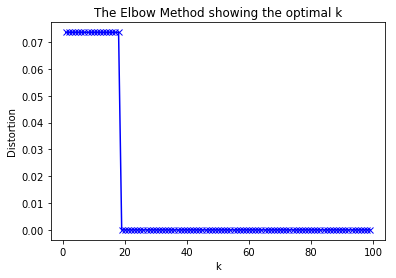

In [307]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('elbow'+method+'.png')

In [330]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, perplexity=20, verbose=2).fit_transform(X_kmeans)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2321 samples in 0.001s...
[t-SNE] Computed neighbors for 2321 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2321
[t-SNE] Computed conditional probabilities for sample 2000 / 2321
[t-SNE] Computed conditional probabilities for sample 2321 / 2321
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.444s
[t-SNE] Iteration 50: error = 65.0737839, gradient norm = 0.0784026 (50 iterations in 3.001s)
[t-SNE] Iteration 100: error = 54.1281204, gradient norm = 0.0433606 (50 iterations in 2.012s)
[t-SNE] Iteration 150: error = 50.8491364, gradient norm = 0.0328969 (50 iterations in 1.833s)
[t-SNE] Iteration 200: error = 49.1697311, gradient norm = 0.0271565 (50 iterations in 1.800s)
[t-SNE] Iteration 250: error = 48.1040573, gradient norm = 0.0239064 (50 iterations in 1.784s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.104057
[t-SNE] Iteration 300: erro

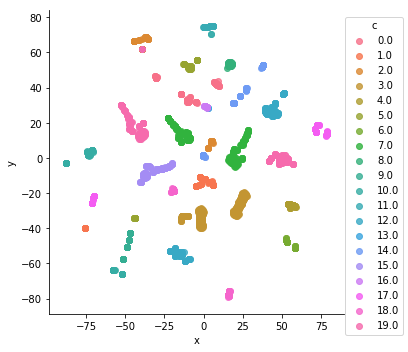

In [331]:
import seaborn as sns
tsne_df = pd.DataFrame(np.append(X_tsne.T,[kmeans_assign],0).T,columns = ['x','y','c'])
sns.lmplot('x', 'y',data = tsne_df, hue='c',size = 5,fit_reg = False)

In [375]:
from sklearn import mixture
n_components_range = range(1, 100)

bic = []
lowest_bic = np.infty


for n_components in n_components_range:
    gmm = mixture.GaussianMixture(n_components=n_components,
                                  covariance_type='full')
    gmm.fit(X_kmeans)
    bic.append(gmm.bic(X_kmeans))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm  = gmm

In [376]:
lowest_bic

-107377.34124728364

In [377]:
best_gmm

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=74, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [378]:
gmm_cluster = 75
best_gmm.predict(X_kmeans)

array([ 2,  0, 18, ..., 57, 25, 65], dtype=int64)

In [379]:
gmm_df = pd.DataFrame(np.asarray([temp2.index, best_gmm.predict(X_kmeans)]).T,columns = ['nodes','gmm'])

In [381]:
assign_all = pd.merge(temp,kmeans_df, how='inner', on='nodes')
assign_all = pd.merge(assign_all,gmm_df, how='inner', on='nodes').set_index('nodes')
assign_all.to_csv(method+'.csv')